# Libraries

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data.dataset import random_split
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle as pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from itertools import cycle


colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

# Seed

In [2]:
#########################################################################################
#set the seed for random environment
#here we set the seed to 42
#########################################################################################
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
#when import the module the seed is set
seed_everything()

In [10]:
batch_size = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# DATA Preparation

## FCN

### FCN Dataset Preparation 

In [5]:
class WaveFormDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: 数据集的根目录
        """
        self.samples = []
        self.labels = []

        # 自动发现数据和标签
        for label in ['noise', 'internal', 'corona']:
            data_dir = os.path.join(root_dir, label)
            for file in os.listdir(data_dir):
                file_path = os.path.join(data_dir, file)
                if file.endswith('.csv'):
                    # 读取CSV文件，跳过表头
                    data = pd.read_csv(file_path, header=None, skiprows=1, sep='[,\t]', engine='python').values
                    # 对于文件中的每一行，保存为一个独立的样本
                    for row in data:
                        self.samples.append(row.astype(np.float32))
                        self.labels.append(label)
        
        # 将文本标签转换为整数
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 返回单个样本和标签
        sample = self.samples[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float32)
        return sample, label

# 使用示例
root_dir = '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/dataset' # 根据实际路径调整
WaveForm = WaveFormDataset(root_dir=root_dir)


In [6]:
# 假设 dataset 是你的完整数据集
dataset_size = len(WaveForm)
train_size = int(dataset_size * 0.7) # 70% 数据用于训练
val_size = int(dataset_size * 0.15) # 15% 数据用于验证
test_size = dataset_size - train_size - val_size # 剩下的 15% 数据用于测试

train_dataset, val_dataset, test_dataset = random_split(WaveForm, [train_size, val_size, test_size])


### FCN DataLoader 

In [7]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [36]:
for data, label in train_loader:
    print (data.shape)
    break

torch.Size([64, 256])


## CNN

### CNN Dataset Preparation

In [9]:
class WaveFormDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: 数据集的根目录
        """
        self.samples = []
        self.labels = []

        # 自动发现数据和标签
        for label in ['noise', 'internal', 'corona']:
            data_dir = os.path.join(root_dir, label)
            for file in os.listdir(data_dir):
                file_path = os.path.join(data_dir, file)
                if file.endswith('.csv'):
                    # 读取CSV文件，跳过表头
                    data = pd.read_csv(file_path, header=None, skiprows=1, sep='[,\t]', engine='python').values
                    # 对于文件中的每一行，保存为一个独立的样本
                    for row in data:
                        self.samples.append(row.astype(np.float32))
                        self.labels.append(label)
        
        # 将文本标签转换为整数
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 返回单个样本和标签
        sample = self.samples[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        sample = sample.unsqueeze(0) # 添加一个维度，使其成为单通道图像
        label = self.labels[idx]
        if label == 0:
            label = torch.tensor([1, 0, 0], dtype=torch.float32)
        elif label == 1:
            label = torch.tensor([0, 1, 0], dtype=torch.float32)
        else:
            label = torch.tensor([0, 0, 1], dtype=torch.float32)
            
        #label = torch.tensor(label, dtype=torch.float32)
        return sample, label

# 使用示例
root_dir = '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/dataset' # 根据实际路径调整
CNN_WaveForm = WaveFormDataset(root_dir=root_dir)


In [10]:
# 假设 dataset 是你的完整数据集
CNN_dataset_size = len(CNN_WaveForm)
CNN_train_size = int(CNN_dataset_size * 0.7) # 70% 数据用于训练
CNN_val_size = int(CNN_dataset_size * 0.15) # 15% 数据用于验证
CNN_test_size = CNN_dataset_size - CNN_train_size - CNN_val_size # 剩下的 15% 数据用于测试

CNN_train_dataset, CNN_val_dataset, CNN_test_dataset = random_split(CNN_WaveForm, [CNN_train_size, CNN_val_size, CNN_test_size])


In [11]:
for i, data in enumerate(CNN_train_dataset):
    sample, label = data
    print(sample.shape, label)
    break

torch.Size([1, 256]) tensor([0., 0., 1.])


### CNN DataLoader

In [12]:
CNN_train_loader = DataLoader(CNN_train_dataset, batch_size, shuffle=True)
CNN_val_loader = DataLoader(CNN_val_dataset, batch_size, shuffle=False)
CNN_test_loader = DataLoader(CNN_test_dataset, batch_size, shuffle=False)

In [13]:
for data, label in CNN_train_loader:
    print(data.shape, label.shape)
    break

torch.Size([64, 1, 256]) torch.Size([64, 3])


## RNN

### RNN Dataset Preparation

In [4]:
class RNN_Dataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: 数据集的根目录
        """
        self.samples = []
        self.labels = []

        # 自动发现数据和标签
        for label in ['noise', 'internal', 'corona']:
            data_dir = os.path.join(root_dir, label)
            for file in os.listdir(data_dir):
                file_path = os.path.join(data_dir, file)
                if file.endswith('.csv'):
                    # 读取CSV文件，跳过表头
                    data = pd.read_csv(file_path, header=None, skiprows=1, sep='[,\t]', engine='python').values
                    # 对于文件中的每一行，保存为一个独立的样本
                    for row in data:
                        self.samples.append(row.astype(np.float32))
                        self.labels.append(label)
        
        # 将文本标签转换为整数
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 返回单个样本和标签
        sample = self.samples[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        sample = sample.unsqueeze(-1) # 新的形状变为 [64, 256, 1]
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float32)
        return sample, label

# 使用示例
root_dir = '/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/dataset' # 根据实际路径调整
RNN_WaveForm = RNN_Dataset(root_dir=root_dir)


In [5]:
# 假设 dataset 是你的完整数据集
dataset_size = len(RNN_WaveForm)
train_size = int(dataset_size * 0.7) # 70% 数据用于训练
val_size = int(dataset_size * 0.15) # 15% 数据用于验证
test_size = dataset_size - train_size - val_size # 剩下的 15% 数据用于测试

RNN_train_dataset, RNN_val_dataset, RNN_test_dataset = random_split(RNN_WaveForm, [train_size, val_size, test_size])

### RNN DataLoader

In [6]:
RNN_train_loader = DataLoader(RNN_train_dataset, batch_size, shuffle=True)
RNN_val_loader = DataLoader(RNN_val_dataset, batch_size, shuffle=False)
RNN_test_loader = DataLoader(RNN_test_dataset, batch_size, shuffle=False)

In [7]:
for data, label in RNN_train_loader:
    print (data.shape)
    break

torch.Size([64, 256, 1])


# Model

## FCN

In [14]:
CHECKPOINT=False

In [15]:
# Define the FCN model
class FourLayerFCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FourLayerFCN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 添加dropout层，dropout率为0.5
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  # 在激活函数后添加dropout
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # 在激活函数后添加dropout
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)  # 在激活函数后添加dropout
        x = self.fc4(x)
        return x

In [16]:
# Define the input size, hidden size, and number of classes
input_size = len(train_loader.dataset[0][0])
hidden_size = 128
num_classes = 3

In [17]:
# Create an instance of the FourLayerFCN model
model = FourLayerFCN(input_size, hidden_size, num_classes)
model = model.to(device)

In [18]:
# Print the model architecture
summary(model, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          32,896
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
      BatchNorm1d-10                  [-1, 128]             256
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 3]             387
Total params: 67,075
Trainable params: 

In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5949, 1.0, 0.946]).to(device))

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [20]:
# Define the training function
def FCNtrain(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    # Training loop
    total_loss = 0
    total_samples = 0
    total_correct = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (samples, labels) in enumerate(train_loader):
            samples = samples.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(samples)
            loss = criterion(outputs, labels.long())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Statistics
            total_loss += loss.item()
            total_samples += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
        train_loss = total_loss / total_samples
        train_losses.append(train_loss)
        # Validation
        model.eval()
        with torch.no_grad():
            total_loss = 0
            total_samples = 0
            total_correct = 0
            for i, (samples, labels) in enumerate(val_loader):
                samples = samples.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(samples)
                loss = criterion(outputs, labels.long())
                # Statistics
                total_loss += loss.item()
                total_samples += labels.size(0)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
            val_loss = total_loss / total_samples
            val_losses.append(val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}')
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f'/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/checkpoint/FCN/checkpoint_{epoch}.pth')

    return train_losses, val_losses

In [21]:
# Train the model
num_epochs = 10
train_losses, val_losses = FCNtrain(model, train_loader, val_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Train Loss: 0.0007, Val Loss: 0.0001
Epoch [2/10], Train Loss: 0.0002, Val Loss: 0.0000
Epoch [3/10], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [4/10], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [5/10], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [6/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0000


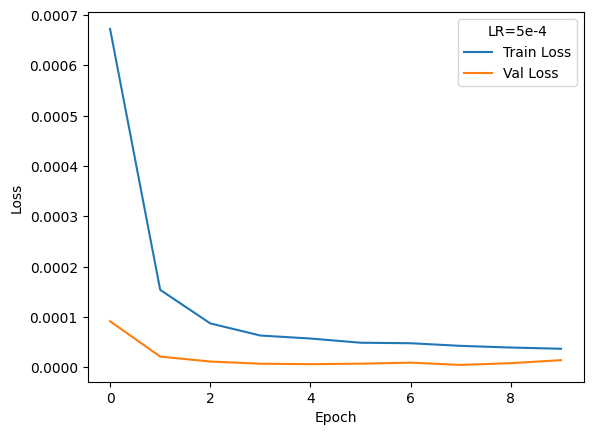

In [22]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='LR=5e-4')
plt.show()

In [23]:
model.eval()
total_samples = 0
total_correct = 0
with torch.no_grad():
    for samples, labels in test_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(samples)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9996


## CNN

In [24]:
# Define the CNN model
class FourLayerCNN(nn.Module):
    def __init__(self, batch_size, num_classes):
        super(FourLayerCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=6, stride=2, padding=2)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=6, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=6, stride=2, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=6, stride=2, padding=2)
        self.bn4 = nn.BatchNorm1d(256)

        self.Pool = nn.AvgPool1d(kernel_size=16, stride=1)

        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.Pool(x)
        
        x = self.fc5(x.view(x.size(0), -1))
        #x = torch.argmax(x, 1)
        #x = torch.tensor(x, dtype=torch.float32)
        #x = x.squeeze(1)
        
        return x

In [25]:
num_classes = 3

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create an instance of the FourLayerCNN model
CNN_model = FourLayerCNN(batch_size,num_classes)
CNN_model = CNN_model.to(device)

In [27]:
# Print the model architecture
summary(CNN_model, (1,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 128]             448
       BatchNorm1d-2              [-1, 64, 128]             128
              ReLU-3              [-1, 64, 128]               0
            Conv1d-4              [-1, 128, 64]          49,280
       BatchNorm1d-5              [-1, 128, 64]             256
              ReLU-6              [-1, 128, 64]               0
            Conv1d-7              [-1, 256, 32]         196,864
       BatchNorm1d-8              [-1, 256, 32]             512
              ReLU-9              [-1, 256, 32]               0
           Conv1d-10              [-1, 256, 16]         393,472
      BatchNorm1d-11              [-1, 256, 16]             512
             ReLU-12              [-1, 256, 16]               0
        AvgPool1d-13               [-1, 256, 1]               0
           Linear-14                   

In [28]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5949, 1.0, 0.946]).to(device))

# Define the optimizer
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=5e-4)

In [29]:
# Define the training function
def CNNtrain(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    # Training loop
    total_loss = 0
    total_samples = 0
    total_correct = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (samples, labels) in enumerate(train_loader):
            samples = samples.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(samples)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Statistics
            total_loss += loss.item()
            total_samples += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            total_correct += (predicted == labels).sum().item()
        train_loss = total_loss / total_samples
        train_losses.append(train_loss)
        # Validation
        model.eval()
        with torch.no_grad():
            total_loss = 0
            total_samples = 0
            total_correct = 0
            for i, (samples, labels) in enumerate(val_loader):
                samples = samples.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(samples)
                loss = criterion(outputs, labels)
                # Statistics
                total_loss += loss.item()
                total_samples += labels.size(0)
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                total_correct += (predicted == labels).sum().item()
            val_loss = total_loss / total_samples
            val_losses.append(val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}')
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f'/media/mldadmin/home/s123mdg34_04/WangShengyuan/FYP/checkpoint/FCN/checkpoint_{epoch}.pth')

    return train_losses, val_losses

In [30]:
# Train the model
num_epochs = 10
train_losses, val_losses = CNNtrain(CNN_model, CNN_train_loader, CNN_val_loader, num_epochs, criterion, optimizer)

Epoch [1/10], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [2/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [3/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [4/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [6/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0000


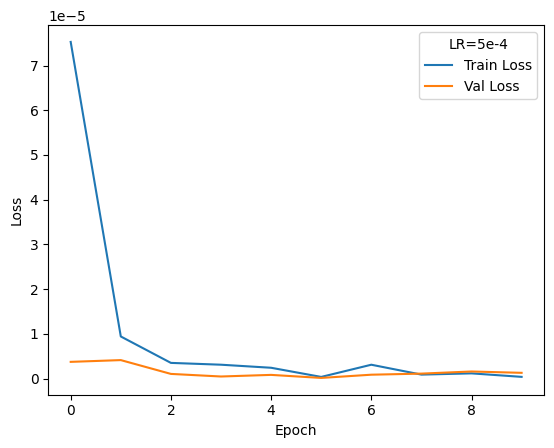

In [31]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='LR=5e-4')
plt.show()

In [32]:
CNN_model.eval()
total_samples = 0
total_correct = 0
with torch.no_grad():
    for samples, labels in CNN_test_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = CNN_model(samples)
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 1.0000


## RNN

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        
        # LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # 全连接层，注意现在输出大小为num_classes
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        output = self.linear(lstm_out[:, -1, :])        
        return output


In [14]:
model = LSTMModel(1, 50, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.5949, 1.0, 0.946]).to(device))

In [15]:
summary(model, input_size=(256,1))

AttributeError: 'tuple' object has no attribute 'size'

In [102]:
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    model.to(device)  # 确保模型已移到正确的设备
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        total_train_samples = 0
        total_val_samples = 0
        train_losses = []
        val_losses = []

        # 训练阶段
        for samples, labels in train_loader:
            samples, labels = samples.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(samples)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * samples.size(0)
            total_train_samples += samples.size(0)
        
        train_loss = total_train_loss / total_train_samples
        train_losses.append(train_loss)

        # 验证阶段
        model.eval()
        with torch.no_grad():
            for samples, labels in val_loader:
                samples, labels = samples.to(device), labels.to(device)
                outputs = model(samples)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * samples.size(0)
                total_val_samples += samples.size(0)
            
            val_loss = total_val_loss / total_val_samples
            val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
    return train_losses, val_losses


In [103]:
#train the model
num_epochs = 10
train_losses, val_losses = train(model, RNN_train_loader, RNN_val_loader, num_epochs, criterion, optimizer)


AttributeError: 'tuple' object has no attribute 'size'

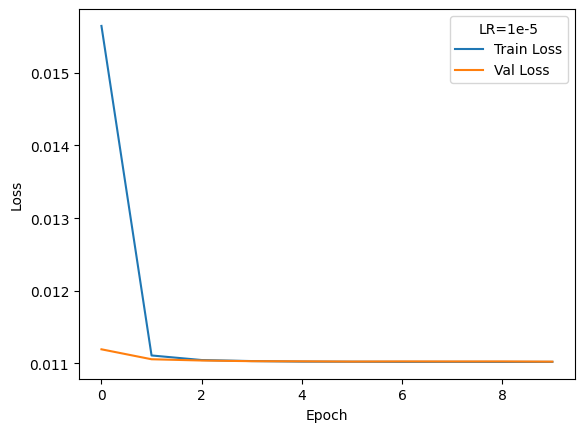

In [104]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='LR=1e-5')
plt.show()

In [105]:
model.eval()
total_samples = 0
total_correct = 0
with torch.no_grad():
    for samples, labels in test_loader:
        samples = samples.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(samples)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')


/media/mldadmin/home/s123mdg34_04/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


RuntimeError: shape '[51200, 1]' is invalid for input of size 200

## SVM

Validation Accuracy: 0.9994
Test Accuracy: 0.9993


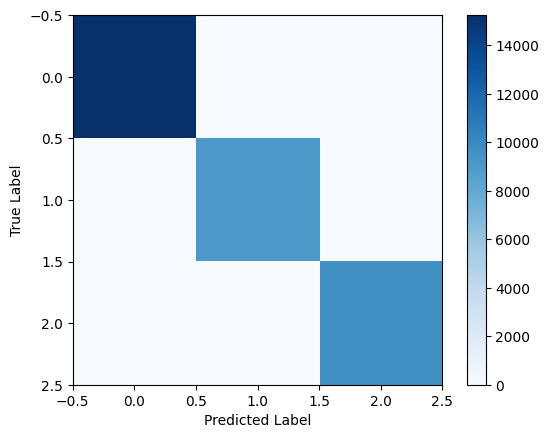

In [64]:
# Load the data
X_train = []
y_train = []
for samples, labels in train_loader:
    samples = samples.numpy()
    labels = labels.numpy()
    X_train.extend(samples)
    y_train.extend(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = []
y_val = []
for samples, labels in val_loader:
    samples = samples.numpy()
    labels = labels.numpy()
    X_val.extend(samples)
    y_val.extend(labels)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = []
y_test = []
for samples, labels in test_loader:
    samples = samples.numpy()
    labels = labels.numpy()
    X_test.extend(samples)
    y_test.extend(labels)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train the SVM model
model = svm.SVC(kernel='rbf', C=1, gamma='auto')
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = np.mean(y_val_pred == y_val)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


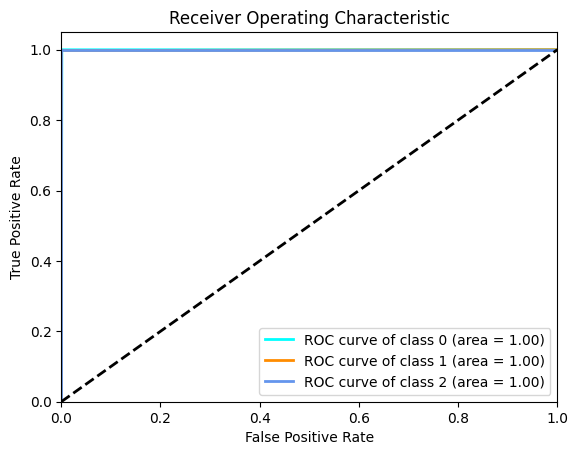

In [65]:

# Plot the ROC curve
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = y_test.astype(int)
y_test_pred = y_test_pred.astype(int)
y_test_one_hot = np.eye(n_classes)[y_test]
y_test_pred_one_hot = np.eye(n_classes)[y_test_pred]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_pred_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
